In [1]:
import fix_project_path

import os
from itertools import combinations
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import wilcoxon
import seaborn as sns
from tqdm.notebook import tqdm

from config import basepaths
from config import Config
from datasets.loader import load_data, DataFoldFactory
from experiment import ExperimentKeys
from paths import ExperimentPaths, makedirs

%load_ext autoreload
%autoreload 2

In [2]:
data_keys = {
    #'gazebase_all_sr1000_sl1000_dxy': "GazeBase (1000 s)",
    'gazebase_all_sr1000_sl5000_savgol_maxvel1000_dxy': "GazeBase",# (5000 s)",
    #'judo_sr1000_sl1000_rxy': "JuDo1000 (right eye)",
    'judo_sr1000_sl1000_savgol_maxvel1000_bxy': "JuDo1000",# (both eyes)",
    'potec_sr1000_sl1000_savgol_maxvel1000_dxy': "PoTeC",
}


segmentation_keys = {
    'ivt.fixation': 'fixation',
    'engbert.saccade': 'saccade',
    #'clip': 'clip',
    #'nan': 'nan',
    #'unclassified': 'unclassified',
}

In [3]:
basepath = Path('/mnt/scratch/anonymous/workspace/xai-timeseries/')
eval_rootdir = Path('/mnt/scratch/anonymous/workspace/xai-timeseries/evaluations/attribution_metrics/')
plot_dirpath = Path('/home/anonymous/workspace/xai-timeseries/plots/segmentation_sizes/')

makedirs(plot_dirpath)

In [4]:
index = pd.MultiIndex.from_product(
    iterables=[
        data_keys.keys(),
        segmentation_keys.keys(),
    ],
    names=['data', 'segmentation'],
)

df = pd.DataFrame(columns=['data', 'instance_id', 'segmentation', 'size', 'ratio'])

display(df)

,data,instance_id,segmentation,size,ratio


In [5]:
fold_indices = {}

for data_key in tqdm(data_keys):
    
    experiment_keys = ExperimentKeys(data_key=data_key)
    config = Config(experiment_keys)
    paths = ExperimentPaths(config, basepath=basepath)

    for segmentation_key in tqdm(segmentation_keys):
        segmentation_filepath = paths.repository / 'events' / f'{segmentation_key}.npy'
        
        segmentation = np.load(segmentation_filepath)
        segmentation_size = segmentation.sum(axis=1)
        segmentation_ratio = segmentation_size / segmentation.shape[-1]
        
        df_seg = pd.DataFrame(columns=df.columns, data={
            'data': data_key,
            'instance_id': range(len(segmentation)),
            'segmentation': segmentation_key,
            'size': segmentation_size,
            'ratio': segmentation_ratio,
        })
        
        df = pd.concat([df, df_seg], ignore_index=True)


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
df = df.reset_index(drop=True)

df.data = df.data.map(data_keys)
df.segmentation = df.segmentation.map(segmentation_keys)

display(df)

,data,instance_id,segmentation,size,ratio
0,GazeBase,0,fixation,4423,0.8846
1,GazeBase,1,fixation,3956,0.7912
2,GazeBase,2,fixation,4117,0.8234
3,GazeBase,3,fixation,3867,0.7734
4,GazeBase,4,fixation,3823,0.7646
...,...,...,...,...,...
695287,PoTeC,107535,saccade,105,0.1050
695288,PoTeC,107536,saccade,144,0.1440
695289,PoTeC,107537,saccade,78,0.0780
695290,PoTeC,107538,saccade,149,0.1490


In [19]:
import matplotlib as mpl

def plot_scores_catplot(
    scores,
    y_column,
    figsize=(15,6),    
    xlabel='', ylabel='score', xticks=None,
    savepath=None, rc_context=None, kind='bar',
    legend=True,
    col_titles="",
):
    sns.set_theme(style = "whitegrid", font_scale=1.4)
    #sns.set_style({'legend.frameon':False})
    
    if rc_context is not None:
        sns.set_context('notebook', font_scale=1.4, rc=rc_context)
    
    #fig = plt.figure(figsize=figsize)
    g = sns.catplot(
        x='segmentation',
        y=y_column,
        col='data',
        #row='metric',
        #hue='explainer',
        data=scores,
        kind=kind,
        ci=68,
        sharex=True,
        sharey=True,
        palette='deep',
        legend=legend,
        #legend_out=True,
        showfliers=False,
    )
    
    if legend:
        sns.move_legend(g, "upper right", title=None, frameon=True, bbox_to_anchor=(1, 1.015))

    #if show_baseline:
    #    g.map(plt.axhline, y=1/n_classes, color=".7", dashes=(2, 1), zorder=0)

    # Adjust title and axis labels directly
    #g.set_titles("{col_name}")
    g.set_titles(col_titles)
    g.set_axis_labels(x_var=xlabel, y_var=ylabel)    
    if xticks:
        g.set(xticks=xticks)
        
    for ax in g.axes.flat:
        #ax = g
        ax.tick_params(
            axis='x',
            which='major',
            direction='out',
            length=6,
            width=2,
            pad=0,
            color='k',
            bottom=True,
            reset=False,
        )

        ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(n=2))
        ax.set_xticklabels(ax.get_xticklabels(), 
                           rotation=45, 
                           horizontalalignment='right',
                           rotation_mode='anchor'
                          )

        #ax.set_xlabel(xlabel)
        #ax.set_ylabel(ylabel)

        ax.grid(False, which='major', axis='x')
        ax.grid(True, which='minor', axis='x')
        ax.grid(True, which='major', axis='y')
        ax.grid(False, which='minor', axis='y')
   
    #plt.legend(legend)
    #ax.get_legend().remove()    
    
    #print(xticklabels)
    #print(dir(xticklabels[0]))
    #ax.set_ylim((0.9*scores['score'].min(), 1.1*scores['score'].max()))
        
    #g.set(ylim=(0, 1))
    g.fig.set_size_inches(*figsize)
    #plt.suptitle(input_key)
    
    plt.tight_layout(pad=0.8)
    #plt.tight_layout()
    
    plt.subplots_adjust(hspace=0.1, wspace=0.1)

    if savepath:
        plt.savefig(savepath, bbox_inches='tight')
    
    plt.show()

/home/anonymous/workspace/xai-timeseries/plots/segmentation_sizes/segmentation-ratio-boxplot.pdf


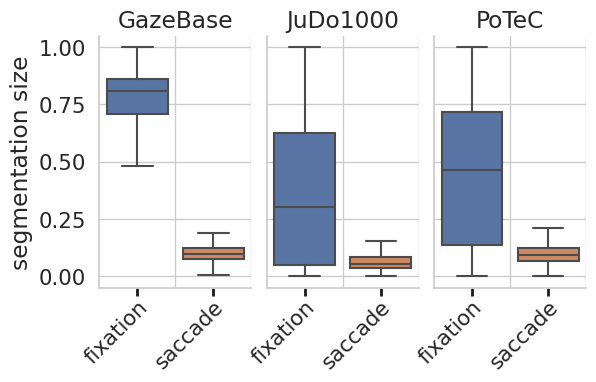

In [20]:
    savepath = plot_dirpath / 'segmentation-ratio-boxplot.pdf'
    print(savepath)
    
    plot_scores_catplot(
        df, y_column='ratio',
        kind='box',
        ylabel='segmentation size',
        figsize=(6, 4),
        legend=False,
        col_titles="{col_name}",
        savepath=savepath,
    )